In [1]:
import numpy as np
import tensorflow as tf
import string
import pandas as pd
from gensim.models import KeyedVectors
import spacy
import model_utils
import constants
import os
import matplotlib.pyplot as plt
import gensim

In [2]:
df = pd.read_json('../../data/translated/sarcasm/sarcasm_headlines_dataset_pl.json')

In [3]:
df = df.drop(columns=['article_link', 'headline'])
df

,is_sarcastic,headline_pl
0,1,Naukowcy z lat trzydziestych odkrywają zegar z...
1,0,"Reprezentantka rządu USA wyjaśnia, dlaczego Ko..."
2,0,Jedz warzywa: 9 pysznie różnych przepisów
3,1,Nieprzyjemna pogoda uniemożliwia kłamcy dotarc...
4,1,"matka jest bardzo blisko użycia słowa ""streami..."
...,...,...
28614,1,Żydzi świętują Rosh Hashasha czy coś
28615,1,Śledczy spraw wewnętrznych rozczarowany spiski...
28616,0,Najpiękniejsza przemowa akceptacyjna w tym tyg...
28617,1,Mars zniszczony przez pałac kosmiczny na orbic...


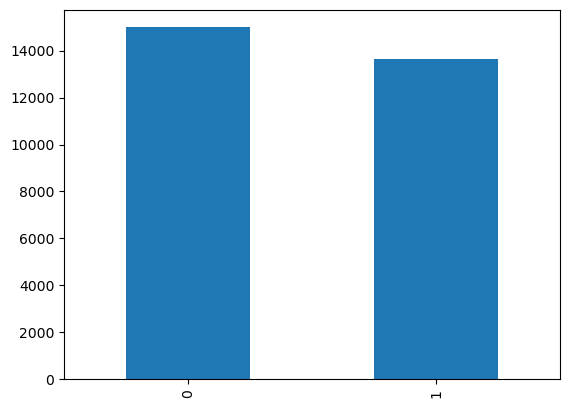

In [4]:
data = df["is_sarcastic"]
data.value_counts().plot.bar()
plt.show()

In [6]:
# !python -m spacy download pl_core_news_sm

     ---------------------------------------- 0.0/20.2 MB ? eta -:--:--
     ---------------------------------------- 0.0/20.2 MB 1.4 MB/s eta 0:00:15
     ---------------------------------------- 0.1/20.2 MB 1.3 MB/s eta 0:00:16
     ---------------------------------------- 0.2/20.2 MB 1.2 MB/s eta 0:00:18
     ---------------------------------------- 0.2/20.2 MB 1.1 MB/s eta 0:00:18
      --------------------------------------- 0.3/20.2 MB 1.4 MB/s eta 0:00:15
      --------------------------------------- 0.5/20.2 MB 1.6 MB/s eta 0:00:13
     - -------------------------------------- 0.6/20.2 MB 1.7 MB/s eta 0:00:12
     - -------------------------------------- 0.7/20.2 MB 1.9 MB/s eta 0:00:11
     - -------------------------------------- 0.8/20.2 MB 1.9 MB/s eta 0:00:10
     - -------------------------------------- 0.9/20.2 MB 2.0 MB/s eta 0:00:10
     -- ------------------------------------- 1.0/20.2 MB 2.1 MB/s eta 0:00:10
     -- ------------------------------------- 1.2/20.2 MB 2

In [5]:
spacy_model = spacy.load("pl_core_news_sm")

In [6]:
# Stop words
stop_words = spacy_model.Defaults.stop_words.copy()
stop_words.remove("nie")
print(stop_words)

{'prawie', 'pan', 'taka', 'takze', 'jednak', 'wtedy', 'taki', 'xiv', 'jakiś', 'ach', 'był', 'ty', 'niego', 'była', 'jestem', 'beda', 'gdzies', 'jedna', 'ma', 'się', 'oraz', 'cię', 'nasz', 'było', 'moj', 'tel', 'jakos', 'te', 'vi', 'jakis', 'cały', 'naszego', 'sam', 'tys', 'twoja', 'cie', 'mu', 'mam', 'będzie', 'jeszcze', 'jemu', 'pod', 'nich', 'go', 'nasze', 'kims', 'mój', 'godz', 'niech', 'przedtem', 'soba', 'bowiem', 'ktorej', 'dlatego', 'zapewne', 'od', 'wasi', 'jakie', 'poniewaz', 'dziś', 'xv', 'który', 'oto', 'ja', 'takie', 'więcej', 'moim', 'wśród', 'poza', 'ale', 'dwie', 'gdzie', 'dwoje', 'duzo', 'zadne', 'według', 'wszystkich', 'żadnych', 'tym', 'byla', 'kilka', 'będą', 'daleko', 'on', 'rowniez', 'one', 'jednym', 'tam', 'kto', 'mną', 'bardzo', 'ona', 'im', 'możliwe', 'wasz', 'bym', 'dwaj', 'żeby', 'swoje', 'że', 'pomimo', 'zadnych', 'viii', 'tak', 'z', 'ktorzy', 'bo', 'które', 'trzeba', 'dlaczego', 'ci', 'byli', 'do', 'żadne', 'żaden', 'niemu', 'totobą', 'mało', 'sie', 'wszyscy

In [7]:
# Punctuation
punctuations = string.punctuation
print(punctuations)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [8]:
# Tokenizer
def spacy_tokenizer(sentence):
    doc = spacy_model(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() for word in doc ]

    # Removing stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [9]:
texts = df['headline_pl'].to_list()
tokenized_sentences = [spacy_tokenizer(text) for text in texts]

In [10]:
# Word2Vec
w2v_model = gensim.models.Word2Vec(sentences=tokenized_sentences, vector_size=100, window=6, min_count=1)

In [11]:
w2v_model.train(tokenized_sentences, epochs=10, total_examples=len(tokenized_sentences))

(2011630, 2077060)

In [12]:
print("The no of words :", len(w2v_model.wv))

The no of words : 32485


In [13]:
def tokens_to_vector(sentence):
    vector_size = w2v_model.vector_size
    wv_res = np.zeros(vector_size)
    ctr = 1
    for w in sentence:
        if w in w2v_model.wv:
            ctr += 1
            wv_res += w2v_model.wv[w]
    wv_res = wv_res/ctr
    return wv_res

In [14]:
vectors = [tokens_to_vector(tokenized_sentence) for tokenized_sentence in tokenized_sentences]

In [15]:
X = np.array(vectors)
Y = df['is_sarcastic'].to_numpy()

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, train_size=0.5, random_state=42)

In [17]:
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='sigmoid'))

In [18]:
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [19]:
# Model parameters
training_number = 1
model_name = 'sarcasm_pl_word2vec_own'
training_name = model_name
figures_dir = f"../../documentation/models/{model_name}/figures"
checkpoint_filename_template = "cp-{epoch:04d}.ckpt"
checkpoints_dir = os.path.join(constants.TRAINING_CHECKPOINTS_PATH, model_name, training_name)
checkpoint_path = os.path.join(checkpoints_dir, checkpoint_filename_template)
batch_size = 32

In [20]:
# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)
callbacks = [checkpoint_cb, early_stop_cb]

In [21]:
history = model.fit(x=X_train, y=Y_train, validation_data=(X_val, Y_val), epochs=10, batch_size=batch_size, callbacks=[checkpoint_cb, early_stop_cb])

Epoch 1/10
716/716 [==============================] - 4s 3ms/step - loss: 0.6405 - accuracy: 0.6237 - val_loss: 0.6365 - val_accuracy: 0.6076

Epoch 00001: saving model to ../../training_checkpoints\sarcasm_pl_word2vec_own\sarcasm_pl_word2vec_own\cp-0001.ckpt
Epoch 2/10
716/716 [==============================] - 2s 2ms/step - loss: 0.6230 - accuracy: 0.6489 - val_loss: 0.6538 - val_accuracy: 0.6150

Epoch 00002: saving model to ../../training_checkpoints\sarcasm_pl_word2vec_own\sarcasm_pl_word2vec_own\cp-0002.ckpt
Epoch 3/10
716/716 [==============================] - 2s 2ms/step - loss: 0.6157 - accuracy: 0.6544 - val_loss: 0.6235 - val_accuracy: 0.6548

Epoch 00003: saving model to ../../training_checkpoints\sarcasm_pl_word2vec_own\sarcasm_pl_word2vec_own\cp-0003.ckpt
Epoch 4/10
716/716 [==============================] - 2s 2ms/step - loss: 0.6108 - accuracy: 0.6592 - val_loss: 0.6258 - val_accuracy: 0.6433

Epoch 00004: saving model to ../../training_checkpoints\sarcasm_pl_word2vec_o

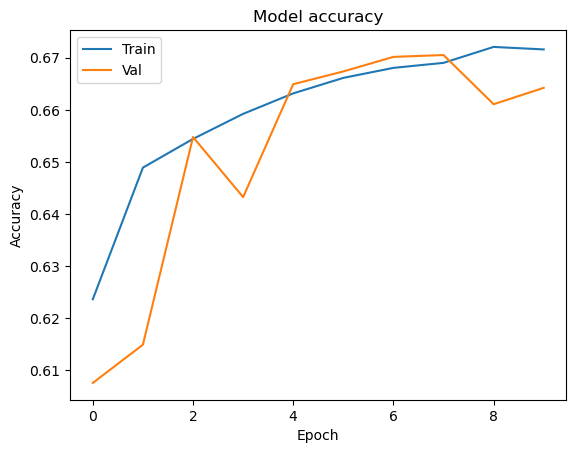

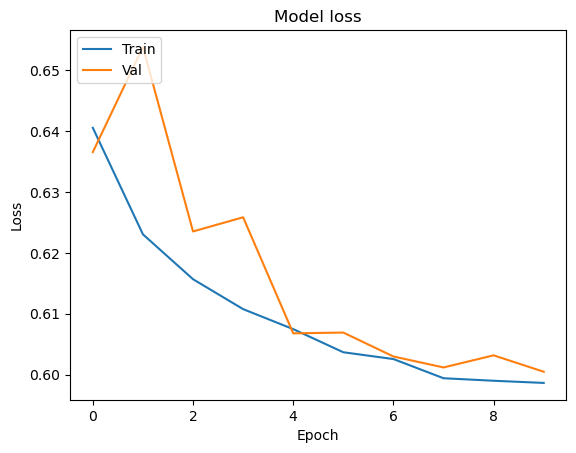

In [22]:
model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['accuracy', 'val_accuracy'],
                                           title='Model accuracy',
                                           y_label='Accuracy',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_accuracy.png")

model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['loss', 'val_loss'],
                                           title='Model loss',
                                           y_label='Loss',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_loss.png")

In [23]:
best_model = model_utils.get_best_model_from_checkpoints(model, history,
                                                         checkpoints_dir=checkpoints_dir,
                                                         checkpoint_filename_template=checkpoint_filename_template)

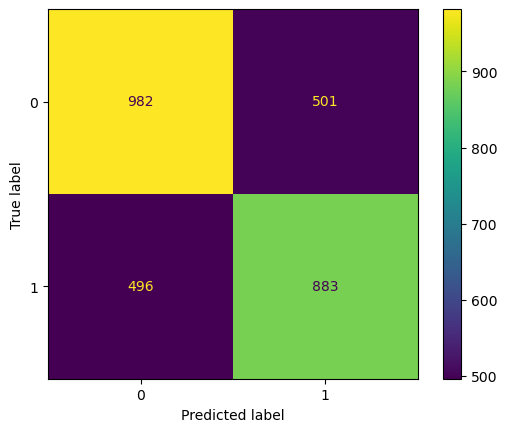

In [24]:
class_preds = model_utils.get_class_preds(best_model, X_test, model_returns_logits=False)
model_utils. plot_and_save_conf_matrix(class_actual=Y_test,
                                      class_preds=class_preds,
                                      figure_dir_path=figures_dir,
                                      figure_filename=f"{training_name}_confmatrix.png")

In [25]:
# Evaluation
best_model.evaluate(X_test, Y_test, batch_size=batch_size)

90/90 [==============================] - 0s 2ms/step - loss: 0.6014 - accuracy: 0.6516


[0.6013844609260559, 0.6516422033309937]

In [26]:
model_utils.save_model(best_model, model_name=model_name, training_number=training_number,
                       saved_models_dir=constants.SAVED_MODEL_LOCATION,
                       default_model_version=constants.DEFAULT_MODEL_VERSION)

INFO:tensorflow:Assets written to: ../../trained_models\sarcasm_pl_word2vec_own_1\1\assets
